Normalizing Flows Implementation for Fashion-MNIST Generation

This module implements a normalizing flow model using affine coupling layers to learn the data distribution of Fashion-MNIST images.  
The model transforms data between the data space and a simple base distribution (standard Gaussian).  

Key components:
- CouplingLayer: Implements affine transformations with learnable scale/shift
- FlowSequential: Chains multiple invertible transformations
- Training pipeline with proper validation and early stopping

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
from torch import Tensor
from typing import Tuple, Callable
from itertools import chain
import copy
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler
from torch.distributions import MultivariateNormal
from models.MLP import MLP
from models.LambdaLayer import LambdaLayer
from utils.utils import visualize_samples

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

scaler = GradScaler(device)

Using cuda device


/tmp/ipykernel_20033/3266725043.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(device)


In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root='../data',
    train=True,
    # download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root='../data',
    train=False,
    # download=True,
    transform=ToTensor(),
)

In [4]:
# Filter for single class (T-shirts/tops) for simpler learning
target_label = 0
training_data_incides = torch.where(training_data.targets == target_label)[0]
test_data_incides = torch.where(test_data.targets == target_label)[0]

training_data = Subset(training_data, training_data_incides)
test_data = Subset(test_data, test_data_incides)

In [5]:
# Train/validation split
val_fraction = 0.1
dataset_size = len(training_data)
val_size = int(val_fraction * dataset_size)
train_size = dataset_size - val_size

# Create a reproducible shuffled list of indices
generator = torch.Generator().manual_seed(42)
indices = torch.randperm(dataset_size, generator=generator).tolist()

# Split indices for train and validation
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Wrap Subsets for train and validation datasets
train_data = Subset(training_data, train_indices)
val_data = Subset(training_data, val_indices)

In [6]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

print(f"Training batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64
Training batches: 47
Test batches: 8


$$
z_B = \exp\left(-s(z_A)\right) \odot \left(x_B - b(z_A)\right)  
$$

$$
J = 
\begin{bmatrix}
I_d & 0 \\
\frac{\partial z_B}{\partial x_A} & \mathrm{diag}\big(\exp(-s)\big)
\end{bmatrix}
$$

$$
x_B = \exp\big(s(z_A, w)\big) \odot z_B + b(z_A, w)
$$

In [7]:
class CouplingLayer(nn.Module):
    """
        Affine coupling layer for normalizing flows.
        
        Splits input into two parts [x_A, x_B], keeps x_A unchanged as z_A,
        and transforms x_B using learned scale s(z_A) and shift b(z_A) functions:
        
        Forward:  z_B = exp(-s(z_A)) ⊙ (x_B - b(z_A))
        Inverse:  x_B = exp(s(z_A)) ⊙ z_B + b(z_A)
        
        Args:
            split_at: Dimension at which to split the input tensor
            scale_net: Neural network computing log-scale parameters s(z_A)  
            shift_net: Neural network computing shift parameters b(z_A)
            alternate_parts: If True, transform first half instead of second half
    """
    def __init__(
        self,
        split_at: int,
        scale_net: nn.Module, # s
        shift_net: nn.Module, # b
        alternate_parts: bool = False
    ) -> None:
        super().__init__()
        self.split_at = split_at
        self.scale_net = scale_net
        self.shift_net = shift_net
        self.alternate_parts = alternate_parts
    

    def _split(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        """Split input tensor into two parts."""
        if self.alternate_parts:
            return x[:, self.split_at:], x[:, :self.split_at]
        else:
            return x[:, :self.split_at], x[:, self.split_at:]


    def _merge(self, xA: Tensor, xB: Tensor) -> Tensor:
        """Merge two tensor parts back together."""
        if self.alternate_parts:
            return torch.cat((xB, xA), dim=1)
        else:
            return torch.cat((xA, xB), dim=1)


    def _get_scale_and_shift(self, zA: Tensor) -> Tuple[Tensor, Tensor]:
        """Compute scale and shift parameters from unchanged part."""
        log_scale = self.scale_net(zA)
        log_scale = torch.clamp(log_scale, min=-5, max=3)  # Stability
        shift = self.shift_net(zA)
        return log_scale, shift


    def forward(self, x: Tensor, log_det_total: Tensor) -> Tuple[Tensor, Tensor]:
        """
            Forward transformation: data → latent space.
            
            Returns:
                z: Transformed tensor
                log_det_total: Updated log determinant for probability computation
        """
        xA, xB = self._split(x)
        zA = xA
        log_scale, shift = self._get_scale_and_shift(zA)

        zB = torch.exp(-log_scale) * (xB - shift)
        z = self._merge(zA, zB)

        log_det_current = -torch.sum(log_scale, dim=1)
        log_det_total = log_det_total + log_det_current
        return z, log_det_total


    def inverse(self, z: Tensor) -> Tensor:
        """Inverse transformation: latent space → data space."""
        zA, zB = self._split(z)
        xA = zA
        log_scale, shift = self._get_scale_and_shift(zA)

        xB = torch.exp(log_scale) * zB + shift
        x = self._merge(xA, xB)
        return x

In [9]:
class FlowSequential(nn.Module):
    """
        Sequential container for normalizing flow layers.
        
        Chains multiple invertible transformations and manages the base distribution
        for sampling and likelihood computation.
        
        Args:
            data_dim: Dimensionality of the data space
            layers: List of invertible transformation modules
    """
    def __init__(self, data_dim: int, layers: nn.Module):
        super().__init__()
        self.layers = nn.ModuleList(layers)

        # Validate that all layers implement the required interface
        for i, module in enumerate(self.layers):
            if not hasattr(module, 'forward') or not hasattr(module, 'inverse'):
                raise TypeError(f"Module at index {i} must implement both 'forward' and 'inverse' methods.")
            
        # Base distribution (standard multivariate Gaussian)
        self.register_buffer('base_mean', torch.zeros(data_dim))
        self.register_buffer('base_cov', torch.eye(data_dim))

    def forward(
        self,
        x: torch.Tensor,
        log_det: torch.Tensor = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
            Transform data to latent space through the flow.
            
            Args:
                x: Input data tensor
                log_det: Running log determinant (initialized to zero if None)
                
            Returns:
                z: Latent representation
                log_det: Total log determinant of the transformation
        """
        if log_det is None:
            log_det = torch.zeros(len(x), device=x.device)
        for module in self.layers:
            x, log_det = module(x, log_det)
        return x, log_det

    def inverse(self, z: torch.Tensor) -> torch.Tensor:
        """Transform from latent space back to data space."""
        for module in reversed(self.layers):
            z = module.inverse(z)
        return z
    
    def __call__(
        self,
        x: torch.Tensor,
        log_det: torch.Tensor = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # Optional: put extra logic here before/after forward
        return self.forward(x, log_det)
    
    def sample(self, num_samples: int, device:str=device) -> Tensor:
        """
            Generate samples by transforming base distribution samples.
            
            Args:
                num_samples: Number of samples to generate
                device: Device to generate samples on
                
            Returns:
                Generated samples in data space
        """
        base_dist = MultivariateNormal(self.base_mean, self.base_cov)
        z = base_dist.sample((num_samples,)).to(device)
        
        # Transform through inverse flow
        with torch.no_grad():
            x = self.inverse(z)
        
        return x
    
    def log_prob(self, x: Tensor):
        z, log_det = self.forward(x)
        
        base_dist = MultivariateNormal(self.base_mean, self.base_cov)
        log_prob_base = base_dist.log_prob(z)
        
        log_prob = log_prob_base + log_det
        return log_prob

In [10]:
# For implementation challange
NORMAL_DIST_CONST = torch.log(torch.tensor(2 * torch.pi, device=device))
def normal_NLL(X: Tensor) -> Tensor:
    """Compute -log p(z) for standard Gaussian"""
    d = X.shape[1]
    const_term = (d / 2) * NORMAL_DIST_CONST.to(X.device)
    squared_term = 0.5 * X.pow(2).sum(dim=1)
    return const_term + squared_term


def flow_NLL_loss(
    z_sample: Tensor,
    total_log_det: Tensor,
) -> Tensor:
    """Flow loss = base NLL - total log det (averaged)"""
    return torch.mean(normal_NLL(z_sample) - total_log_det)

In [11]:
def run_epoch(
        model: nn.Module,
        data_loader: DataLoader,
        device: str,
        optimizer,
        training_mode: bool = True,
    ) -> float:
    """
    Run a single epoch in either training or evaluation mode.
    
    Args:
        model: The model to train/evaluate
        dataloader: DataLoader for the dataset
        device: Device to run on (cuda/cpu)
        optimizer: Optimizer for training (required if train_mode=True)
        train_mode: If True, run in training mode; if False, run in evaluation mode
        max_grad_norm: Maximum gradient norm for clipping (only used in training)
    
    Returns:
        average_loss: Average loss for the epoch
    """
    total_loss, num_batches = 0, 0
    
    for data, _ in tqdm(data_loader, total=len(data_loader)):
        data = data.to(device)
        if training_mode:
            optimizer.zero_grad()
        
        # Compute negative log likelihood
        log_prob = model.log_prob(data)
        loss = -log_prob.mean()
        
        if training_mode:
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    return avg_loss
    

In [12]:
def save_model_with_train_state(
    checkpoint_path: str,
    model: nn.Module,
    epoch: int,
    optimizer,
    scheduler,
    train_avg_loss: float,
    val_avg_loss: float,
    train_losses: list,
    val_losses: list,
):
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_avg_loss,
        'val_loss': val_avg_loss,
        'train_losses': train_losses,
        'val_losses': val_losses
    }, checkpoint_path)


def load_best_model(
        model: nn.Module,
        checkpoint_path: str,
        device: str
) -> nn.Module:
    """Load the best saved model from checkpoint."""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Loaded model from epoch {checkpoint['epoch']} with validation loss: {checkpoint['val_loss']:.4f}")
    
    return model

In [17]:
def train_flow(
        model: nn.Module,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        device: str,
        num_epochs: int = 50,
        lr: float = 1e-4,
        patience: int = 10,
        save_path: str = "../models/best_model.pth"
    ) -> Tuple[list, list]:
    """
        Train the normalizing flow model with early stopping.
        
        Args:
            model: Flow model to train
            train_dataloader: Training data loader
            val_dataloader: Validation data loader
            device: Device to train on
            num_epochs: Maximum number of epochs
            lr: Learning rate
            patience: Early stopping patience
            save_path: Path to save best model
            
        Returns:
            Training and validation loss histories
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_epoch = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_avg_loss = run_epoch(
            model, train_dataloader, device, optimizer, True)

        
        model.eval()
        with torch.no_grad():
            val_avg_loss = run_epoch(
                model, val_dataloader, device, optimizer, False)
        
        scheduler.step()
        train_losses.append(train_avg_loss)
        val_losses.append(val_avg_loss)


        if val_avg_loss < best_val_loss:
            best_val_loss = val_avg_loss
            best_epoch = epoch + 1
            epochs_without_improvement = 0

            save_model_with_train_state(
                save_path, model, epoch, optimizer, scheduler,
                train_avg_loss, val_avg_loss, train_losses, val_losses,
            )
            
            print(f'Epoch {epoch+1} completed. Train Loss: {train_avg_loss:.4f}, '
                  f'Val Loss: {val_avg_loss:.4f} # NEW BEST MODEL #')
        else:
            epochs_without_improvement += 1
            print(f'Epoch {epoch+1} completed. Train Loss: {train_avg_loss:.4f}, '
                  f'Val Loss: {val_avg_loss:.4f} (Best: {best_val_loss:.4f} at epoch {best_epoch})')
        

        if (epoch + 1) % 1 == 0:
            samples = model.sample(16, device).cpu()
            visualize_samples(samples, epoch+1)

        # Early stopping check
        if epochs_without_improvement >= patience:
            print(f'\nEarly stopping triggered after {patience} epochs without improvement.')
            print(f'Best validation loss: {best_val_loss:.4f} at epoch {best_epoch}')
            break

    return train_losses, val_losses

In [18]:
flow_net = FlowSequential(
    784, # 28*28 flattened image
    [
        LambdaLayer(img_to_vec, vec_to_img), # Flatten image
        LambdaLayer(add_noise, lambda x: x), # Dequantization
        LambdaLayer(sigmoid_inverse, torch.sigmoid),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device)),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device), True),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device)),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device), True),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device)),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device), True),
    ]

).to(device)


In [19]:
# Test forward pass
x_sample = next(iter(train_dataloader))[0].to(device)
x_to_z = flow_net(x_sample, 0)

100%|██████████| 5/5 [00:00<00:00, 96.96it/s]


Epoch 1 completed. Train Loss: 706350866.9508, Val Loss: 1707.0490 # NEW BEST MODEL #


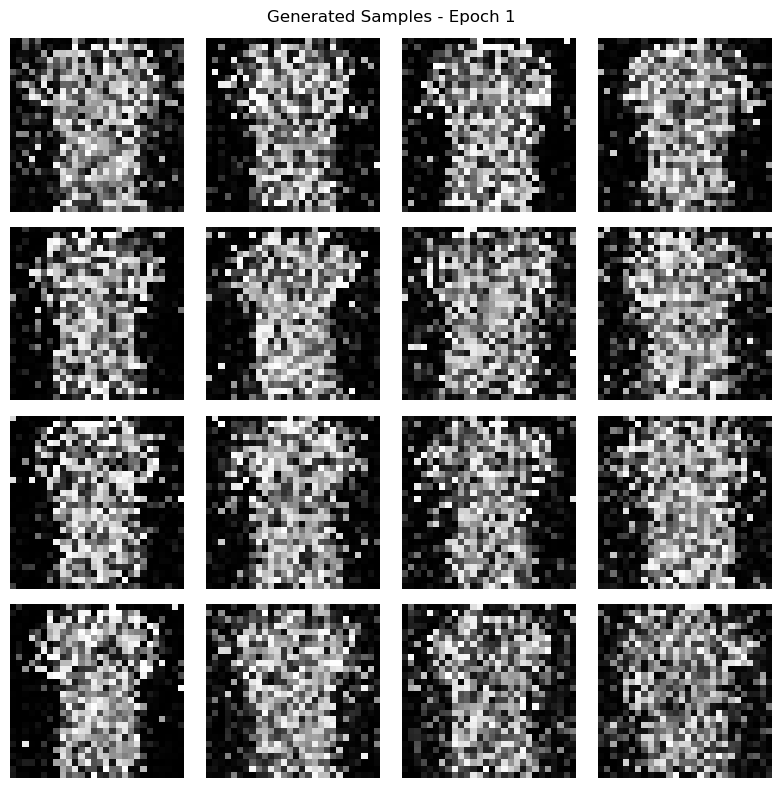

100%|██████████| 5/5 [00:00<00:00, 98.17it/s]


Epoch 2 completed. Train Loss: 1582.0900, Val Loss: 1495.5457 # NEW BEST MODEL #


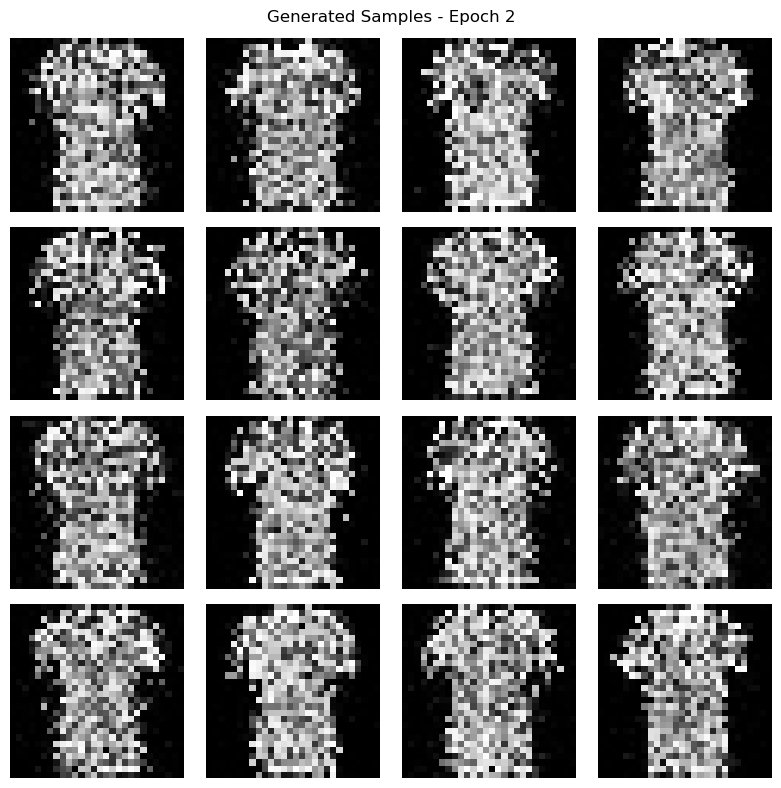

100%|██████████| 5/5 [00:00<00:00, 85.90it/s]


Epoch 3 completed. Train Loss: 1435.1697, Val Loss: 1375.5751 # NEW BEST MODEL #


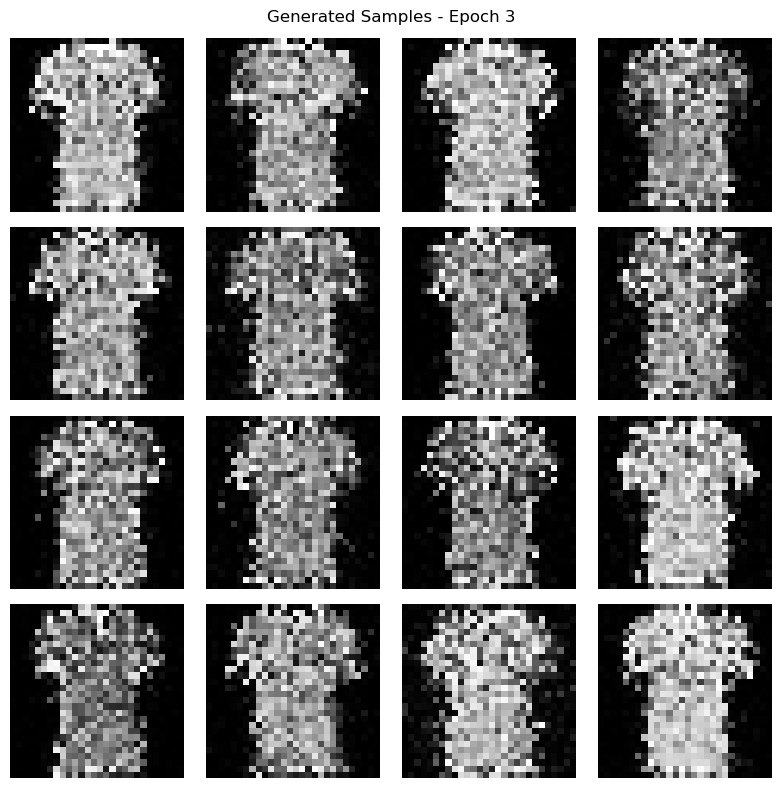

 66%|██████▌   | 31/47 [00:00<00:00, 59.62it/s]


KeyboardInterrupt: 

In [20]:
model_save_path = '../models/coupling_model.pth'
train_losses, val_losses = train_flow(
    flow_net, train_dataloader, val_dataloader, device,
    num_epochs=100, lr=1e-4, save_path=model_save_path)

In [19]:
def plot_losses(train_losses: list, val_losses: list):
    """
    Plots training and validation loss curves.

    Args:
        train_losses (List[float]): Training loss values per epoch.
        val_losses (List[float]): Validation loss values per epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

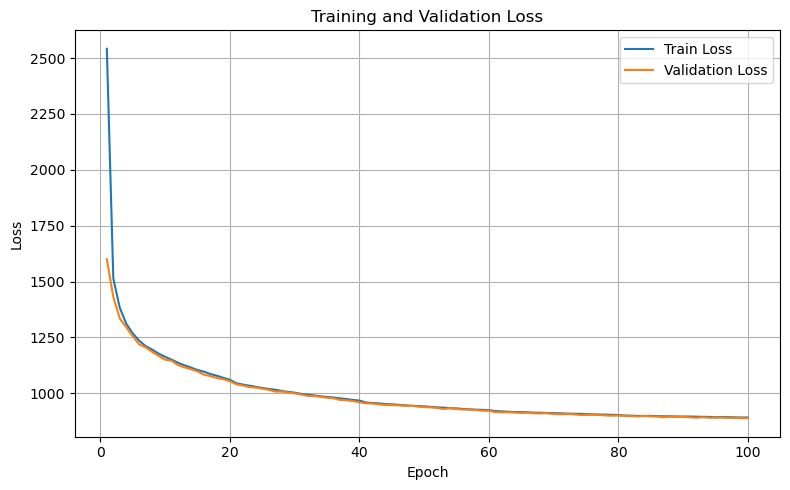

In [20]:
plot_losses(train_losses, val_losses)

In [ ]:
# Test reconstruction quality
def test_reconstruction(
    model: nn.modules,
    test_dataloader: DataLoader,
    device: str,
    num_samples: int = 8
):
    """Test reconstruction quality by encoding and decoding real images."""
    model.eval()
    with torch.no_grad():
        # Get a batch of real data
        real_data, _ = next(iter(test_dataloader))
        real_data = real_data[:num_samples].to(device)
        
        # Forward pass to latent space
        z, _ = model.forward(real_data)
        
        # Reconstruct
        reconstructed = model.inverse(z)
        
        # Convert back to images
        real_images = real_data.squeeze(1).cpu()
        reconstructed_images = reconstructed.cpu()
        
        # Visualize
        fig, axes = plt.subplots(2, num_samples, figsize=(12, 4))
        for i in range(num_samples):
            axes[0, i].imshow(real_images[i], cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            axes[1, i].imshow(reconstructed_images[i], cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    model.train()


Loaded model from epoch 100 with validation loss: 887.8459


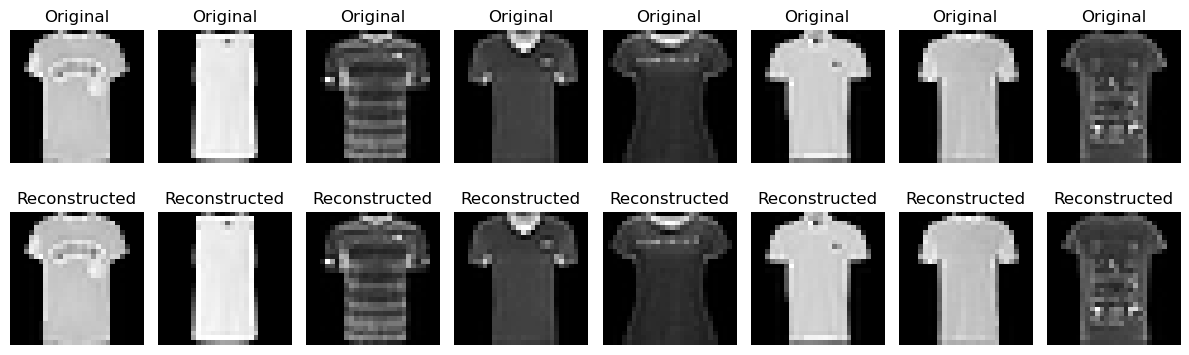

In [22]:
flow_net = load_best_model(flow_net, model_save_path, device)
test_reconstruction(flow_net, test_dataloader, device)